# Setting Up - Install Packages in the Workspace
Before you move on to the project instruction, follow the cells below to ensure you have the necessary packages installed. 
The cells below will also educate you on installing newer pinned packages, should you need them in the future. 

In [ ]:
# Step 1. Update the PATH env var. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/home/student/.local/bin"
os.environ['PATH'] = f"{os.environ['PATH']}:/opt/conda/lib/python3.10/site-packages"
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

In [ ]:
# Check the version of any specific package
!python -m pip freeze | grep numpy

# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [ ]:
!pip -q install .

The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [ ]:
# Restart the Kernel. 
# If you skip this step, your notebook may not be able to import the packages well. 


In [1]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

Found path: /data/Banana_Linux_NoVis/Banana.x86_64
Mono path[0] = '/data/Banana_Linux_NoVis/Banana_Data/Managed'
Mono config path = '/data/Banana_Linux_NoVis/Banana_Data/MonoBleedingEdge/etc'
Preloaded 'libgrpc_csharp_ext.x64.so'
Unable to preload the following plugins:
	libgrpc_csharp_ext.x86.so
Logging to /home/student/.config/unity3d/Unity Technologies/Unity Environment/Player.log


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Train an RL agent on the DQN Network

We will now train an Agent for the banana game using the DQN Algorithm

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os
import numpy as np

import random
from collections import namedtuple, deque

In [5]:
# Define the QNetwork as composed of Linear Layers with RELU activation
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [6]:
# Check if the QNetwork is able to function by passing some random numbers and checking
# if it is outputting 4 numbers
qn = QNetwork(state_size=state_size, action_size=action_size, seed=12345)

In [7]:
tn = torch.randn(37)

pred = qn(tn)

In [8]:
pred

tensor([ 0.0328, -0.0403,  0.0100, -0.1820], grad_fn=<AddBackward0>)

In [9]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
device

device(type='cuda', index=0)

In [12]:
# Define the ReplayBuffer
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [13]:
# Define the Agent to interact with the environment.
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [14]:
# Define an Agent by passing the state dimensions and the size of the action space
agent = Agent(state_size=state_size, action_size=action_size, seed=12345)

In [16]:
# Now we define the method train_dqn
def train_dqn(num_episodes = 2000):
    
    eps_min = 0.01    ## Minimum value for the Epsilon
    eps_start = 1.0   ## The epsilon starts with 1 to give more chance to exploration
    eps_decay = 0.995 ## Decay factor for Epsilon
    
    epsilon = eps_start
    
    scores = []
    scores_window = deque(maxlen=100)
    
    # Loop across the episdes
    for episode in range(num_episodes):
        # Reset the environment
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0] 
        score = 0
        
        # Limit to 2000 iterations
        for i in range(2000):
            action = agent.act(state, epsilon)
            env_info = env.step(action)[brain_name] 
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            
            agent.step(state, action, reward, next_state, done)
            score += reward
            state = next_state
            
            if done:
                if episode % 50 == 0:
                    print(f"Episode {episode+1} ended in {i+1} iterations")
                break
        
        # Append the scores
        scores.append(score)
        scores_window.append(score)
        
        epsilon = min(eps_min, (epsilon*eps_decay))
        avg_score = np.mean(scores_window)
        print('\rEpisode {} \tAverage score: {: .2f}'.format(episode, avg_score), end="")
        if episode % 100 == 0:
            print('\rEpisode {} \tAverage score: {: .2f}'.format(episode, avg_score))
        
        if avg_score >= 13:      # check if environment is solved
            print('\nEnvironment solved in {: d} episodes!\tAverage Score: {: .2f}'.format(episode - 100, avg_score))
            torch.save(agent.qnetwork_local.state_dict(), 'dqn.pth')
            break
    return scores

In [17]:
# Now we train the agent
scores = train_dqn(num_episodes=2000)

Episode 1 ended in 300 iterations
Episode 0 	Average score:  0.00
Episode 49 	Average score:  0.20Episode 51 ended in 300 iterations
Episode 99 	Average score:  0.16Episode 101 ended in 300 iterations
Episode 100 	Average score:  0.18
Episode 149 	Average score:  0.71Episode 151 ended in 300 iterations
Episode 199 	Average score:  2.00Episode 201 ended in 300 iterations
Episode 200 	Average score:  1.98
Episode 249 	Average score:  3.65Episode 251 ended in 300 iterations
Episode 299 	Average score:  5.57Episode 301 ended in 300 iterations
Episode 300 	Average score:  5.70
Episode 349 	Average score:  8.06Episode 351 ended in 300 iterations
Episode 399 	Average score:  10.46Episode 401 ended in 300 iterations
Episode 400 	Average score:  10.47
Episode 449 	Average score:  12.33Episode 451 ended in 300 iterations
Episode 477 	Average score:  13.00
Environment solved in  377 episodes!	Average Score:  13.00


## 4. Plot the scores

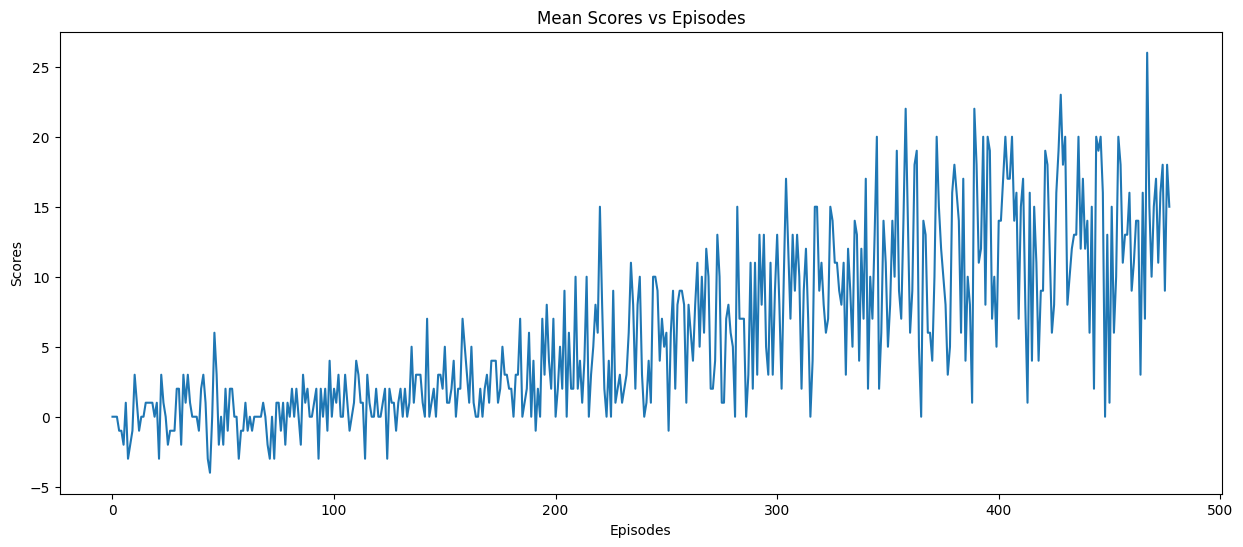

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
plt.plot(scores)
plt.title('Mean Scores vs Episodes')
plt.xlabel('Episodes')
plt.ylabel('Scores')
plt.show()

## 5.0 We play the agent for one episode and see how many yellow bananas it can collect

In [24]:
agent.qnetwork_local.load_state_dict(torch.load('dqn.pth'))

<All keys matched successfully>

In [25]:
# Now we use the agent to play the game
env_info = env.reset(train_mode=True)[brain_name]
state = env_info.vector_observations[0] 
score = 0
while True:
    action = agent.act(state)
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations[0]
    rewards = env_info.rewards[0]
    done = env_info.local_done[0]
    score += rewards
    state = next_state
    if done:
        break

In [26]:
print(f"Score is {score}")

Score is 14.0


In [27]:
env.close()